## Uploading data to postgres
This module will upload the data that I processed earlier. I've already loaded these files into this directory so I can read them in directly

In [46]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# establish connection to the pg database
conn = psycopg2.connect(dbname = "dcde",
                       user = "meetup",
                       password = "DcData11!",
                       host = "python-demo.c5jwjrmfpxfq.us-east-1.rds.amazonaws.com")

cur = conn.cursor()

# this statement is used to delete a table before creating it in order to assure no collusions
# be sure to always replace your name

cur.execute("DROP TABLE IF EXISTS [last name]_dom_box_office")
q = '''
    CREATE TABLE [last name]_dom_box_office(
        title_id character varying,
        date date,
        daily int,
        day int,
        day_of_week int
    )
'''
cur.execute(q)

cur.execute("DROP TABLE IF EXISTS [last name]_title_info")
q = '''
    CREATE TABLE [last name]_title_info(
        title_id character varying PRIMARY KEY,
        title character varying,
        dom_total_sales int,
        int_total_sales int,
        dom_distributer character varying,
        dom_opening int,
        budget int
    )
'''

cur.execute(q)
conn.commit()

This establishes connection to the database and executes a couple of SQL queries to create tables. I need to specify the column names and data type while creating tables. I also prefer to drop a table in case it exists before creating a new one to avoid errors.

In [9]:
with open('domestic_sales_for_db.csv', 'r') as f:
    # Skip the header row.
    next(f)
    cur.copy_from(f, '[last name]_dom_box_office', sep=',')
with open('overall_title_for_db.csv', 'r') as f:
    # Skip the header row.
    next(f)
    cur.copy_expert("COPY [last name]_title_info FROM STDIN WITH CSV HEADER QUOTE '\"'",f)
conn.commit()
conn.close()

My data is in the database now. I checked pgadmin to confirm.
<br><br>
## Exploratory Data Analysis (EDA)
Now that the data is safely stored, I'm going to pull it back into python and explore it a bit

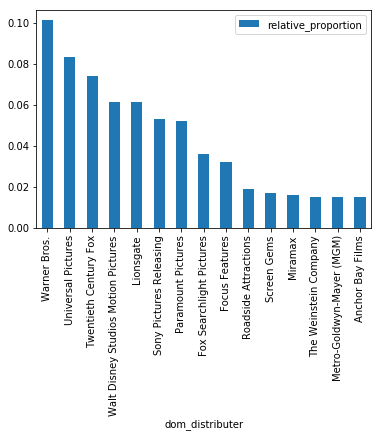

In [28]:
# establish connection to the pg database again
conn = psycopg2.connect(dbname = "dcde",
                       user = "meetup",
                       password = "DcData11!",
                       host = "python-demo.c5jwjrmfpxfq.us-east-1.rds.amazonaws.com")

q = '''
    SELECT dom_distributer, COUNT(dom_distributer)
    FROM [last name]_title_info
    GROUP BY dom_distributer
    ORDER BY 2 DESC
'''

result = pd.read_sql(q,conn)
result['relative_proportion']=result['count']/sum(result['count'])
result.head(15).plot(x='dom_distributer',y='relative_proportion',kind='bar')

I'm curious to see which movies in my sample have the highest ROI (most profitable)

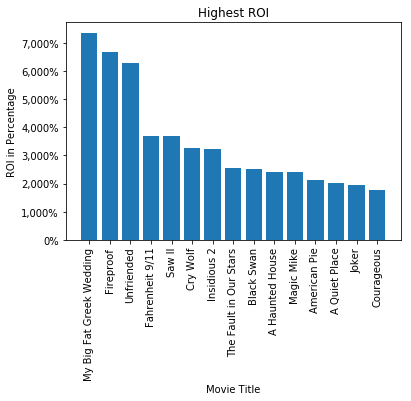

In [49]:
q = '''
    SELECT title, dom_total_sales, int_total_sales, budget 
    FROM [last name]_title_info
'''

result = pd.read_sql(q,conn)
result['roi']=(result['dom_total_sales']+result['int_total_sales'])/result['budget']*100
result=result.sort_values(by=['roi'],ascending=False)

result=result.head(15)
plt.bar(result['title'],result['roi'])
tick_val = [0,1000,2000,3000,4000,5000,6000,7000]
tick_lab = ['0%', '1,000%', '2,000%','3,000%','4,000%','5,000%','6,000%','7,000%']
plt.yticks(tick_val,tick_lab)
plt.xticks(rotation='vertical')
plt.title('Highest ROI')
plt.xlabel('Movie Title')
plt.ylabel('ROI in Percentage')
plt.show()

I'm going to join the data and see which movies have the highest gross revenue on a Friday.

In [50]:
q = '''
    SELECT * FROM [last name]_title_info AS pt
    INNER JOIN [last name]_dom_box_office AS pd ON pd.title_id=pt.title_id
'''
result = pd.read_sql(q,conn)
conn.close()

In [51]:
result.head()

,title_id,title,dom_total_sales,int_total_sales,dom_distributer,dom_opening,budget,title_id,date,daily,day,day_of_week
0,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-06-28,5015267,1,2
1,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-06-29,4307385,2,3
2,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-06-30,6860000,3,4
3,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-07-01,8560000,4,5
4,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-07-02,6990000,5,6


This is what the two datasets look like when they're joined

In [53]:
only_friday_sales = result[result['day_of_week']==4]
print(only_friday_sales.info())
only_friday_sales.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9399 entries, 2 to 64897
Data columns (total 12 columns):
title_id           9399 non-null object
title              9399 non-null object
dom_total_sales    9399 non-null int64
int_total_sales    9399 non-null int64
dom_distributer    9394 non-null object
dom_opening        9399 non-null int64
budget             9399 non-null int64
title_id           9399 non-null object
date               9399 non-null object
daily              9399 non-null int64
day                9399 non-null int64
day_of_week        9399 non-null int64
dtypes: int64(7), object(5)
memory usage: 954.6+ KB
None


,title_id,title,dom_total_sales,int_total_sales,dom_distributer,dom_opening,budget,title_id,date,daily,day,day_of_week
2,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-06-30,6860000,3,4
9,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-07-07,4363000,10,4
16,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-07-14,2973000,17,4
23,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-07-21,1796000,24,4
30,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-07-28,1269000,31,4


I just realized that higher budget movies may have multiple Friday gross sales in the top 15, I need to ensure that day is less than 8 so that everything is from the first week.

In [54]:
first_fridays = only_friday_sales[only_friday_sales['day']<8]
print(first_fridays.info())
first_fridays.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925 entries, 2 to 64897
Data columns (total 12 columns):
title_id           925 non-null object
title              925 non-null object
dom_total_sales    925 non-null int64
int_total_sales    925 non-null int64
dom_distributer    924 non-null object
dom_opening        925 non-null int64
budget             925 non-null int64
title_id           925 non-null object
date               925 non-null object
daily              925 non-null int64
day                925 non-null int64
day_of_week        925 non-null int64
dtypes: int64(7), object(5)
memory usage: 93.9+ KB
None


,title_id,title,dom_total_sales,int_total_sales,dom_distributer,dom_opening,budget,title_id,date,daily,day,day_of_week
2,tt0187393,The Patriot,113330342,101964000,Sony Pictures Releasing,22413710,110000000,tt0187393,2000-06-30,6860000,3,4
54,tt0283897,Assassination Tango,1013272,-1,United Artists,64474,-1,tt0283897,2003-03-28,17277,1,4
152,tt0475998,The Pirates Who Don't Do Anything: A VeggieTal...,12981269,266456,Universal Pictures,4251320,-1,tt0475998,2008-01-11,1116395,1,4
208,tt0204946,Bring It On,68379000,22070929,Universal Pictures,17362105,11000000,tt0204946,2000-08-25,6318885,1,4
341,tt1549920,The Last Stand,12050299,36280458,Lionsgate,6281433,45000000,tt1549920,2013-01-18,2032835,1,4


In [55]:
result=result.sort_values(by=['daily'],ascending=False)
result=result.head(15)

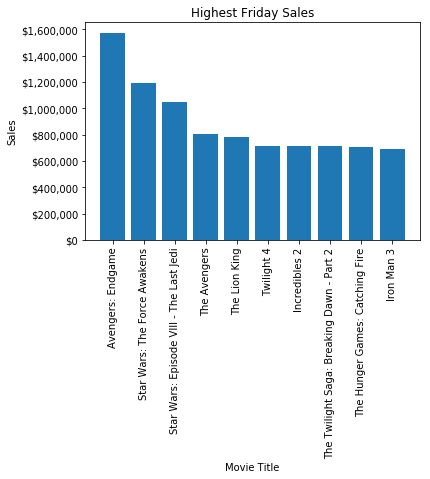

In [65]:
plt.bar(result['title'],result['daily'])
#plt.yticks(tick_val,tick_lab)
plt.xticks(rotation='vertical')
tick_val = [0,20000000,40000000,60000000,80000000,100000000,120000000,140000000,160000000]
tick_lab = ['$0', '$200,000', '$400,000','$600,000','$800,000','$1,000,000','$1,200,000','$1,400,000','$1,600,000']
plt.yticks(tick_val,tick_lab)
plt.title('Highest Friday Sales')
plt.xlabel('Movie Title')
plt.ylabel('Sales')
plt.show()

That's not surprising at all